In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [24]:
JSON_DATA_PATH = "/Users/sreeharirammohan/Desktop/SCP_FOLDER/video_2/json"
FPS = 29.970

In [4]:
all_json_files = os.listdir(JSON_DATA_PATH)

In [5]:
#order the json files from the first frame to the last. 
all_json_files.sort()

In [6]:
#first item in the list is the DS STORE, remove
del all_json_files[0]

In [7]:
print(len(all_json_files))

929


In [8]:
filename = os.path.join(JSON_DATA_PATH, all_json_files[1])

In [9]:
print(filename)

/Users/sreeharirammohan/Desktop/SCP_FOLDER/video_2/json/video_000000002459_keypoints.json


In [10]:
def compute_midpoint(json_file_data, person_number, keypoint1_id, keypoint2_id):
    segment_1_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint1_id]
    segment_1_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_2_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id]
    segment_2_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    return ((segment_1_x + segment_2_x)/2 , (segment_1_y + segment_2_y)/2 )

In [11]:
'''
Calculate Euclidian Distance 2D
'''

def calculate_distance(json_file_data, person_number, keypoint1_id, keypoint2_id):
    
    keypoint1_id = int(keypoint1_id)
    
    keypoint2_id = int(keypoint2_id)
    
    segment_1_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint1_id]
    segment_1_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_1_xy = [segment_1_x, segment_1_y]
    
    segment_2_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id]
    segment_2_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_2_xy = [segment_2_x, segment_2_y]
    
    from scipy.spatial import distance
    
    distance = distance.euclidean(segment_1_xy, segment_2_xy)

    return distance

In [12]:
'''
This method finds the angle between the 8-9 and 9-10 segments. 
'''
def determine_angle_for_json_file(json_file_data, person_number, segment1, segment2):
    
    first_coordinate = int(segment1.split('-')[0])
    
    second_coordinate = int(segment1.split('-')[1])
    
    redundant_second_coordinate = int(segment2.split('-')[0])
    
    third_coordinate = int(segment2.split('-')[1])
    
    if not redundant_second_coordinate == second_coordinate:
        print("ERROR: Two points you find the angle between must be adjacent (share a common vertex)")
        return None
    
    #print(first_coordinate, second_coordinate, third_coordinate)
    
    #No people detected in the scene
    if (len(json_file_data["people"]) == 0):
        return
    
    # 8th segment x, y
    x_8 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*first_coordinate]
    y_8 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*first_coordinate + 1]

    # 9th segment x, y
    x_9 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*second_coordinate]
    y_9 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*second_coordinate + 1]

    #10th
    x_10 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*third_coordinate]
    y_10 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*third_coordinate + 1]
    
    
    if (x_9 == x_8 or x_10 == x_9):
        return 180 #standing straight up
    
    slope_8_9 = (y_9 - y_8)/(x_9 - x_8)
    slope_9_10 = (y_10 - y_9)/(x_10 - x_9)
    
    temp_calc = (slope_9_10 - slope_8_9)/(1 + slope_8_9*slope_9_10)
    
    angle_rad = np.arctan(temp_calc)
    
    angle = angle_rad * (180/np.pi)
    
    
    if(angle < 0):
        angle = -angle
    
    
        
    return angle
    

In [13]:
#Features Extracting from video
#Angle between segment 9-10-11 & 12-13-14 (leg angle should be 90 when squatting)
#Distance between segment 1 & 10  and 1 & 13 (Back Knee angle should be smaller when squatting)
#Distance between Segment (4 & 23) and segment (7 & 20) distance between hands and toes should be minimized while squatting

In [14]:
frame_number = 0

knee_angle = np.array([])
back_to_mid_knee_dist = np.array([])
hands_and_toes_dist = np.array([])

angles = []

for name in all_json_files:
    
    filename = os.path.join(JSON_DATA_PATH, name)
    
    with open(filename, 'r') as j:
        json_file_data = json.load(j)
        angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="8-9", segment2='9-10')
        
        
        knee_1_angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="8-9", segment2='9-10')
        knee_2_angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="12-13", segment2='13-14')
        knee_angle = np.append(knee_angle, knee_1_angle + knee_2_angle)
        
        back_knee_dist_1 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="1", keypoint2_id='10')
        back_knee_dist_2 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="1", keypoint2_id='13')
        back_to_mid_knee_dist = np.append(back_to_mid_knee_dist, back_knee_dist_1 + back_knee_dist_2)
        
        hands_and_toes_1 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="4", keypoint2_id='23')
        hands_and_toes_2 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="7", keypoint2_id='20')
        hands_and_toes_dist = np.append(hands_and_toes_dist, hands_and_toes_1 + hands_and_toes_2)
            
        angles.append(angle)
        frame_number += 1    
        

signal = knee_angle + back_to_mid_knee_dist + hands_and_toes_dist

In [15]:
len(angles)

929

In [16]:
frame_number

929

In [25]:
frame_x = list(range(0, frame_number))

In [27]:
#Calculate minimum distance between peaks
FIVE_STS = 11.34
FIVE_STS_SD = 2.44

MIN_THRESH = FIVE_STS - 2*FIVE_STS_SD #97.5% of patients will be above this value

MIN_THRESH /= 5 # time for 1 STS

MIN_FRAMES = MIN_THRESH * FPS

print(MIN_FRAMES)

38.72124


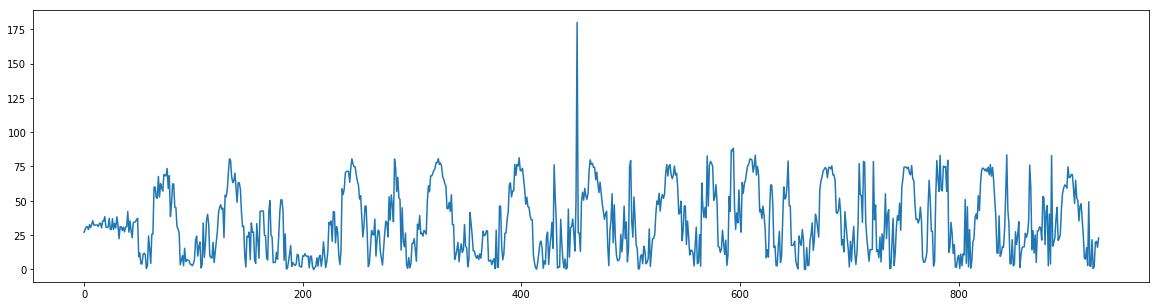

In [18]:
plt.figure(figsize=(20,5))

plt.plot(frame_x, angles)
# count the number of times the person squatted based on the number of times the angle is 90 degrees

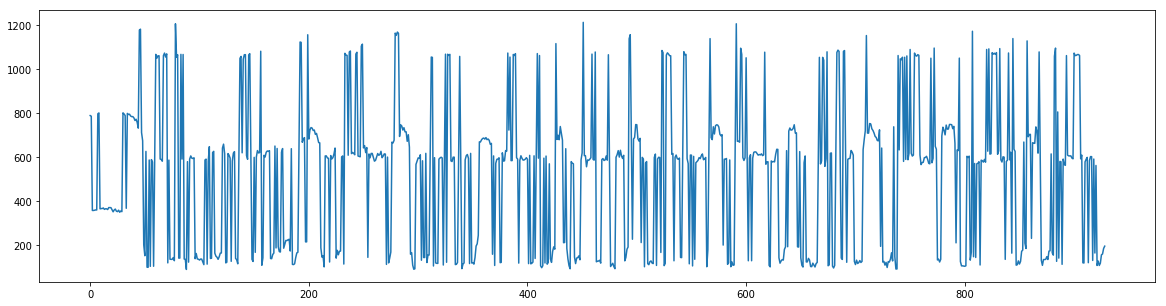

In [19]:
plt.figure(figsize=(20,5))

plt.plot(frame_x, signal)

The patient squated 12 times


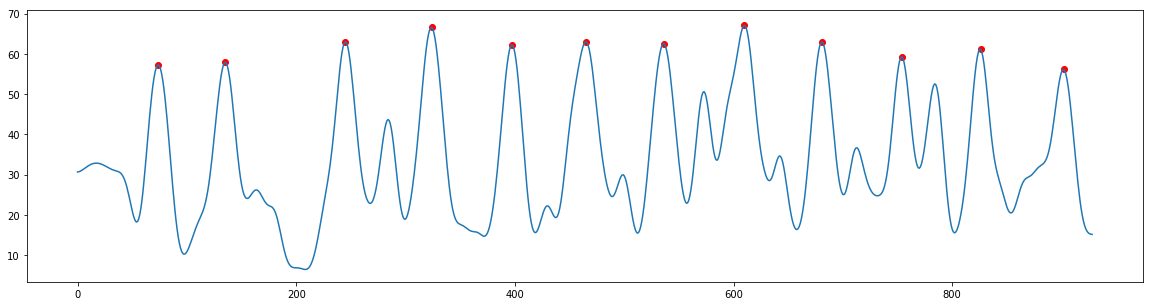

In [30]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks

y_filtered = gaussian_filter1d(angles, 6)
plt.figure(figsize=(20,5))

plt.plot(frame_x, y_filtered)

peak_indexes = find_peaks(y_filtered, distance=MIN_FRAMES, height=50)

peak_x = []
peak_y = []

for peak_index in list(peak_indexes[0]):
    peak_x.append(frame_x[peak_index])
    peak_y.append(y_filtered[peak_index])
    
plt.scatter(peak_x, peak_y, c='red')



print("The patient squated {} times".format(len(peak_y)))

The patient squated 11 times


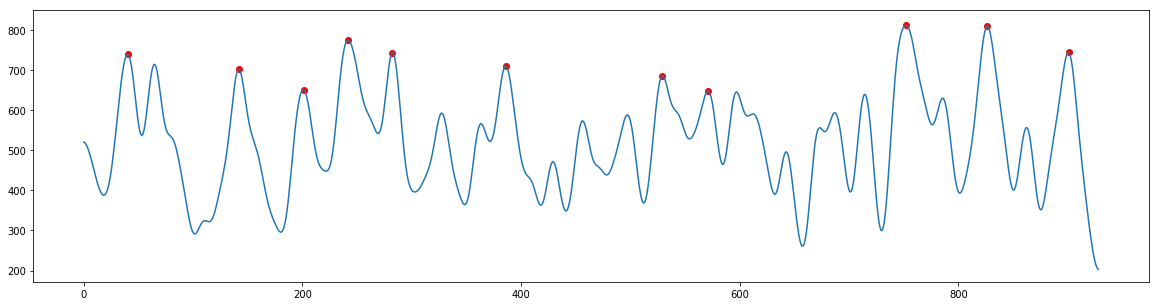

In [31]:
y_filter_signal = gaussian_filter1d(signal, 6)
plt.figure(figsize=(20,5))

plt.plot(frame_x, y_filter_signal)

peak_indexes = find_peaks(y_filter_signal, distance=MIN_FRAMES, height=600)

peak_x = []
peak_y = []

for peak_index in list(peak_indexes[0]):
    peak_x.append(frame_x[peak_index])
    peak_y.append(y_filter_signal[peak_index])
    
plt.scatter(peak_x, peak_y, c='red')


print("The patient squated {} times".format(len(peak_y)))


In [18]:
json_file_data["people"][0]

{'face_keypoints_2d': [],
 'face_keypoints_3d': [],
 'hand_left_keypoints_2d': [],
 'hand_left_keypoints_3d': [],
 'hand_right_keypoints_2d': [],
 'hand_right_keypoints_3d': [],
 'pose_keypoints_2d': [472.949,
  223.671,
  0.851208,
  433.827,
  234.068,
  0.756772,
  442.903,
  235.46,
  0.779556,
  454.656,
  278.545,
  0.73852,
  440.349,
  294.166,
  0.196527,
  427.277,
  226.316,
  0.606573,
  0,
  0,
  0,
  0,
  0,
  0,
  375.074,
  301.987,
  0.519537,
  379.012,
  304.581,
  0.568668,
  457.319,
  318.927,
  0.739473,
  458.611,
  401.222,
  0.582541,
  369.851,
  299.403,
  0.393886,
  459.899,
  317.665,
  0.548177,
  449.488,
  401.191,
  0.565165,
  471.662,
  214.557,
  0.844839,
  0,
  0,
  0,
  454.701,
  209.331,
  0.821199,
  0,
  0,
  0,
  476.872,
  411.653,
  0.163969,
  0,
  0,
  0,
  441.602,
  410.317,
  0.535615,
  487.313,
  412.935,
  0.665607,
  478.197,
  416.855,
  0.599619,
  450.789,
  411.652,
  0.476894],
 'pose_keypoints_3d': []}

In [17]:
determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="8-9", segment2='9-10')

22.991717871657467